In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread, imsave

from scipy.ndimage.interpolation import rotate

from utils import hls_threshold
from utils import applyCombinedGradient

from utils import mag_thresh, dir_threshold

from utils import showImageList
from utils import pipelineBinaryImage
from utils import pipelineBinaryImage2
from utils import pipelineBinaryImage3
from utils import pipelineBinaryImage4

import platform

from Pipeline import Pipeline
from utils import pipelineBinaryImage

%matplotlib inline

In [3]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [4]:
#
# load test images from test_images directory
#
# read with skimage.io.imread (RGB mode)

filenames = sorted( os.listdir("./test_images/") )
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )

#undistort_filenames = sorted( os.listdir("./undistort/") )
#undistort_images = list( map( lambda x: imread( os.path.join("./undistort",x)), filenames) )

undist_ops = lambda img:cv2.undistort(img, mtx, dist, None, mtx)
undist_images = list( map( undist_ops, images ) )

gray_ops = lambda im:cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
undist_gray_images = list( map( gray_ops, undist_images ) )


In [6]:
x = undist_images[2]

In [51]:
binary_warped = mag_thresh(x, sobel_kernel=15, mag_thresh=(80, 200))
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

In [54]:
binary_warped = dir_threshold(x, sobel_kernel=15, thresh=(0.7, 1.3) )
binary_warped = binary_warped.astype(np.uint8)
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) *255


In [55]:
df = pd.DataFrame(out_img.ravel(), columns=["direction"])

In [56]:
df["direction"].value_counts()

0      1667583
255    1097217
Name: direction, dtype: int64

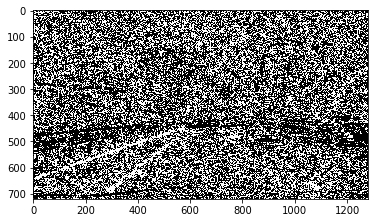

In [57]:
plt.imshow(out_img)

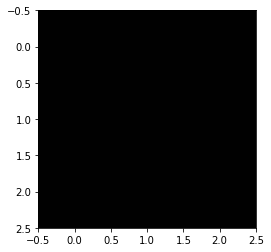

In [47]:
plt.imshow(np.ones((3,3,3) ) * 255 )

In [6]:
from utils import pipelineBinaryImage, pipelineBinaryImage2

In [40]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



In [44]:
src = np.float32([[180, test_image.shape[0]], [575, 460], 
                  [705, 460], [1150, test_image.shape[0]]])

region_bottom_left = (180, test_image.shape[0])
region_top_left = (575,460)
region_top_right = (705,460)
region_bottom_right = (1150,test_image.shape[0])

vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)


In [45]:
masked_image = region_of_interest(test_image,vert)

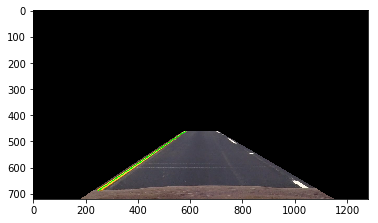

In [46]:
plt.imshow(masked_image)

# load image 

In [3]:
filenames = sorted( os.listdir("./test_images/") )
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )

In [5]:
hls = cv2.cvtColor(images[6], cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]


In [9]:
thresh = (15, 100)
binary = np.zeros_like(S)
binary[(L > thresh[0]) & (L <= thresh[1])] = 1


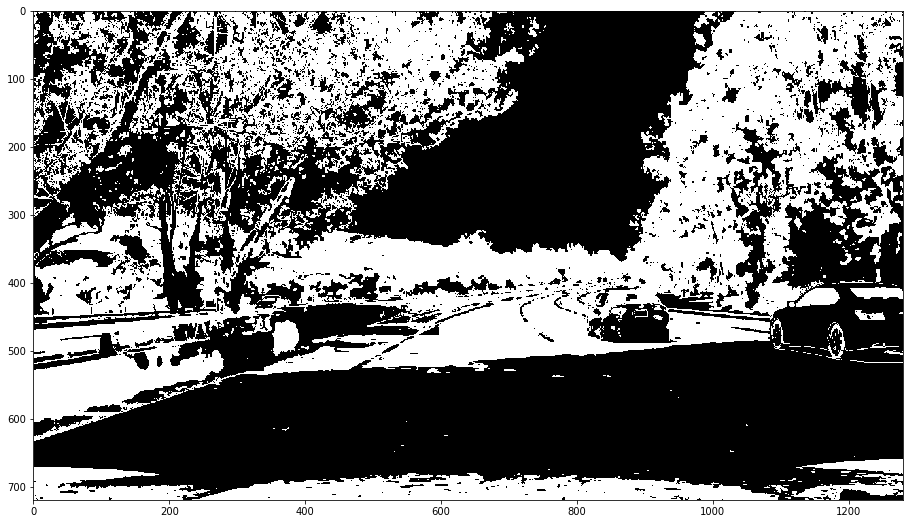

In [10]:
plt.figure(figsize=(16,9))
plt.imshow(binary,cmap="gray")

In [23]:
# check image sizes
width, height = binary.shape

thetas = np.deg2rad(np.arange(-90, 90))
#width, height = img.shape
diag_len = np.ceil(np.sqrt(width * width + height * height)).astype(np.int)   # max_dist
rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

# Cache some resuable values
cos_t = np.cos(thetas)
sin_t = np.sin(thetas)
num_thetas = len(thetas)

print(num_thetas,diag_len)

180 1469


In [47]:
binary = pipelineBinaryImage(images[2])

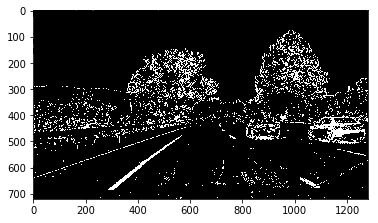

In [48]:
plt.imshow(binary,cmap="gray")

In [57]:
minLineLength = 20
maxLineGap = 100
lines = cv2.HoughLinesP(binary,1,np.pi/180,100,minLineLength,maxLineGap)

In [58]:
len(lines)
test_image = images[2]

In [59]:
for x1,y1,x2,y2 in lines[0]:
    print(x1,y1,x2,y2)
    cv2.line(test_image,(x1,y1),(x2,y2),(0,255,0),2)


553 0 940 0


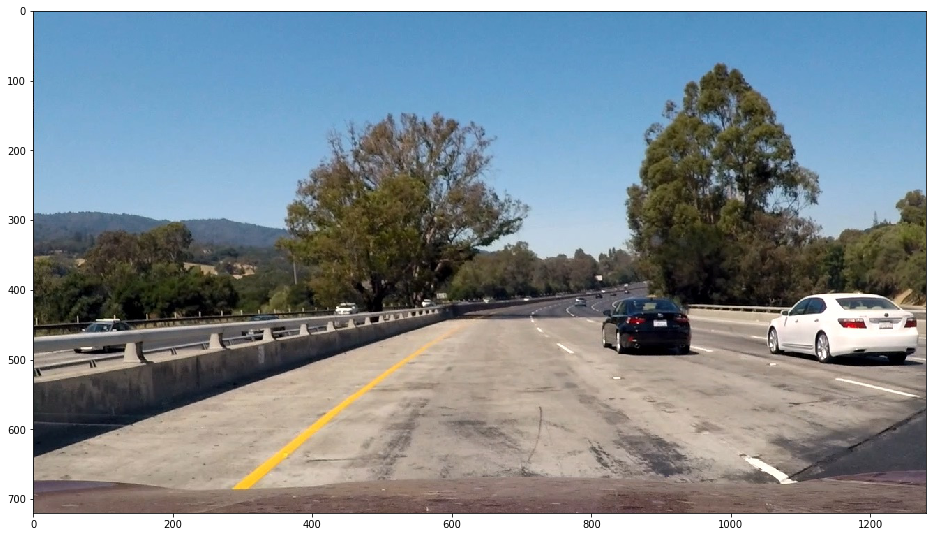

In [60]:
plt.figure(figsize=(16,10))
plt.imshow(test_image)